# Project Title: Movie Recommendation System
## Course: DSC680 - Applied Data Science  
### Submitted By: Sheetal Munjewar  
### Institution: Bellevue University


## Load Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.sparse as sparse
from surprise.model_selection import train_test_split

from surprise import SVD
from surprise import accuracy
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import Reader
from collections import defaultdict
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity


## Environment Configurations

In [2]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)
import warnings
warnings.filterwarnings('ignore')

## Load Data Files

In [3]:
rating=pd.read_csv("dataset/ratings.csv")
link=pd.read_csv("dataset/links.csv")
movies=pd.read_csv("dataset/movies.csv")

tags=pd.read_csv("dataset/tags.csv")
genome_scores=pd.read_csv("dataset/genome-scores.csv")
genome_tags=pd.read_csv("dataset/genome-tags.csv")

metadata = pd.read_csv("dataset/movies_metadata.csv")



### Movies dataset

In [4]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


### Establish connections between dataset and IMDb/TMDB using keys

In [6]:
link.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


### Rating dataset

In [8]:
rating.head(5)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [9]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


### Scoring dataset

In [10]:
genome_scores.head(5)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [11]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


### Tags dataset

In [12]:
genome_tags.head(5)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [13]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


### Metadata dataset

In [14]:
metadata.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [15]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

## EDA

### Extract Movie Year from Title

In [16]:
movies["year"] = movies.title.str.extract('(\(\d{4}\))')
movies.year = movies.year.str.extract('(\d+)')
movies.year = pd.to_numeric(movies.year)

### Movies by Decade

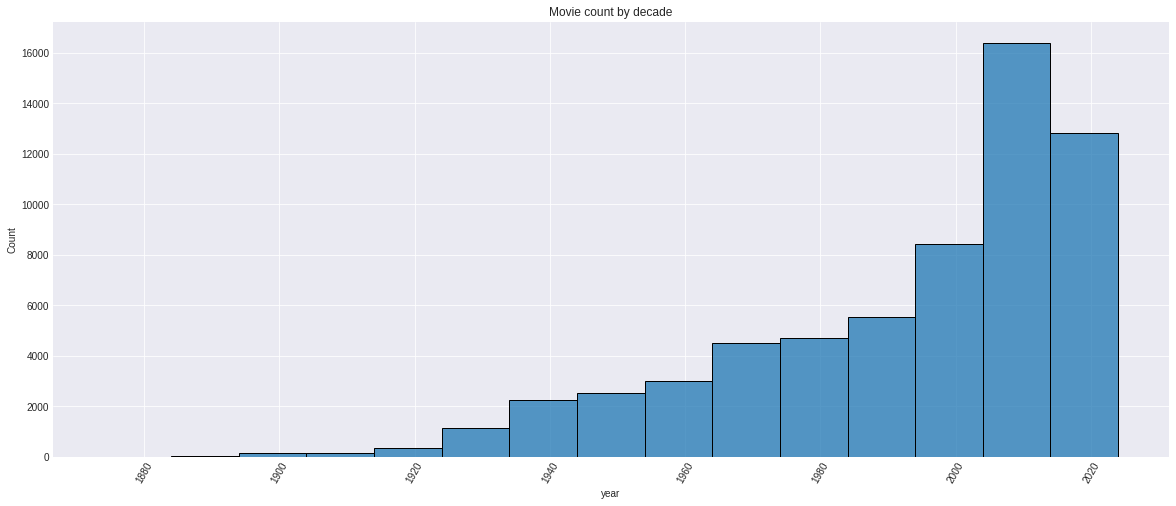

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
p1=sns.histplot(data=movies, x='year', ax=ax, binwidth=10)
plt.title('Movie count by decade')
plt.xticks(rotation=60)
plt.show()

### Split genre column to dummy columns

In [18]:
genres = movies.genres.str.get_dummies().add_prefix('g_')
movies = pd.concat([movies, genres], axis=1)

In [19]:
movies.head(5)

,movieId,title,genres,year,g_(no genres listed),g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,...,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Movies by genre

In [20]:
g_cols = [ col for col in movies.columns if col.startswith("g_")] 

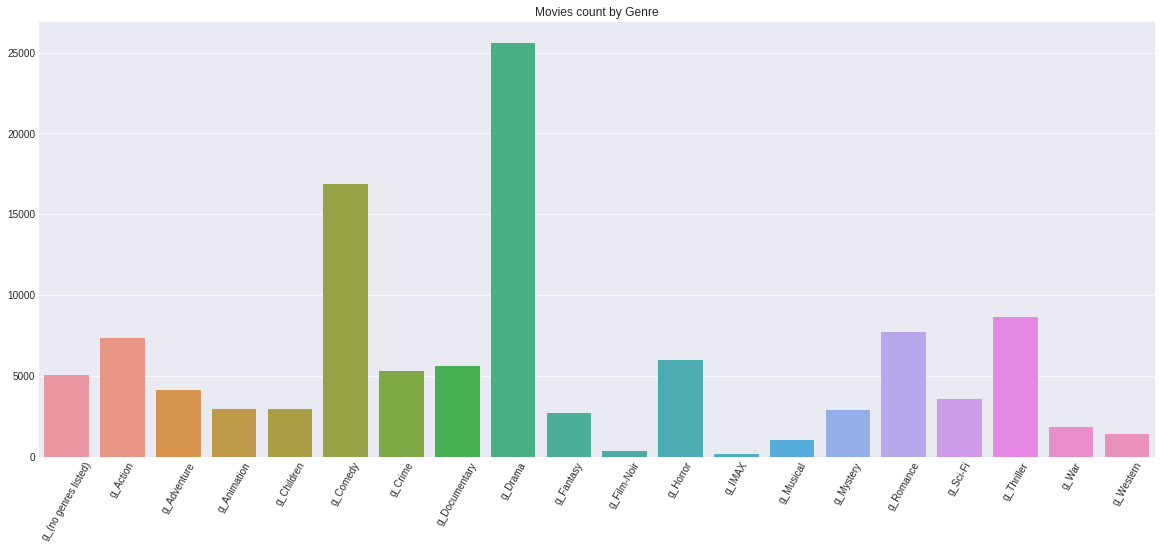

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))
p1=sns.barplot(x=g_cols, y=movies[g_cols].sum(), ax=ax)
plt.title('Movies count by Genre')
plt.xticks(rotation=60)
plt.show()

### Movies by decade and genre

In [22]:
by_decade_genres= movies[g_cols].groupby(np.floor(movies.year/10)*10).sum()
by_decade_genres = by_decade_genres.transpose()
for col in by_decade_genres.columns:
    by_decade_genres[col] = by_decade_genres[col]/by_decade_genres[col].sum()

by_decade_genres

year,1870.0,1880.0,1890.0,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
g_(no genres listed),0.5,0.285714,0.317073,0.188596,0.108262,0.069296,0.055246,0.036784,0.046450,0.053372,0.054807,0.048158,0.041693,0.031572,0.040628
g_Action,0.0,0.000000,0.016260,0.035088,0.025641,0.021322,0.024701,0.028634,0.041352,0.059923,0.087920,0.085627,0.080099,0.066805,0.064451
g_Adventure,0.0,0.000000,0.000000,0.021930,0.045584,0.041578,0.035060,0.031938,0.053059,0.061841,0.038822,0.044242,0.037444,0.033972,0.030556
g_Animation,0.0,0.000000,0.008130,0.021930,0.022792,0.030917,0.046215,0.046476,0.030967,0.015021,0.017356,0.027625,0.022049,0.025184,0.026648
g_Children,0.0,0.000000,0.008130,0.008772,0.014245,0.007463,0.012218,0.020705,0.018693,0.021253,0.024092,0.028366,0.034076,0.028154,0.027019
g_Comedy,0.0,0.000000,0.105691,0.214912,0.273504,0.176972,0.180080,0.148678,0.119147,0.148130,0.129139,0.164691,0.162284,0.148989,0.149387
g_Crime,0.0,0.000000,0.000000,0.035088,0.025641,0.024520,0.061355,0.064537,0.065521,0.056568,0.067710,0.043395,0.049792,0.045852,0.037033
g_Documentary,0.5,0.714286,0.317073,0.057018,0.011396,0.031983,0.005843,0.007489,0.006986,0.019815,0.021809,0.022756,0.029907,0.061150,0.084736
g_Drama,0.0,0.000000,0.040650,0.070175,0.247863,0.308102,0.239575,0.220044,0.246224,0.235379,0.230190,0.198984,0.234285,0.236950,0.223738
g_Fantasy,0.0,0.000000,0.105691,0.223684,0.045584,0.025586,0.011687,0.016520,0.015483,0.022691,0.020096,0.032917,0.026780,0.025510,0.023652


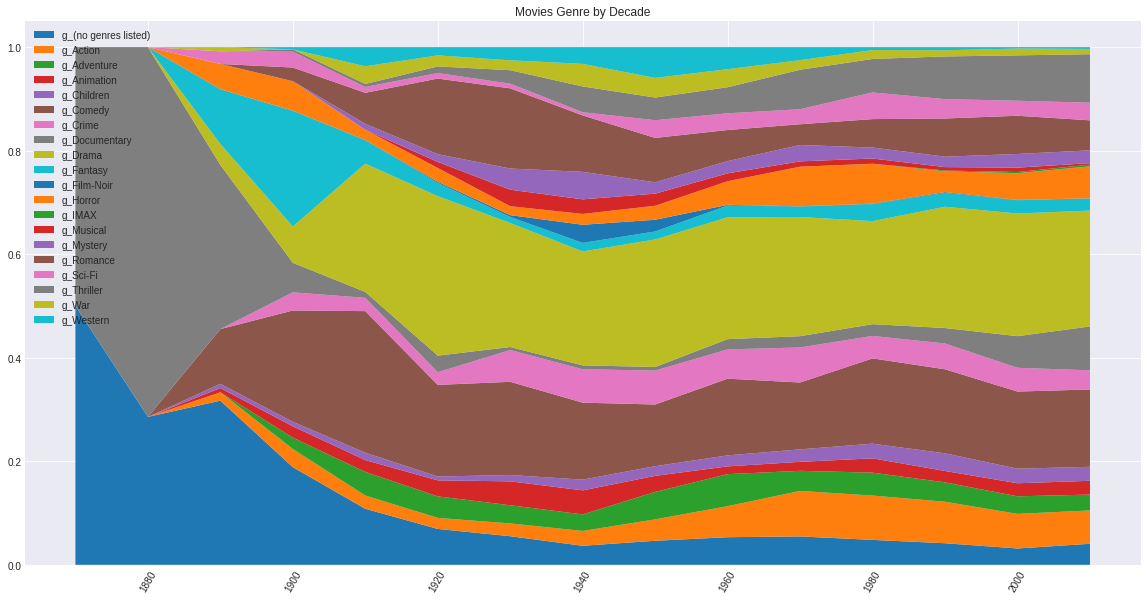

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
p1=plt.stackplot(by_decade_genres.columns, by_decade_genres, labels=by_decade_genres.index)
plt.title('Movies Genre by Decade')
plt.xticks(rotation=60)
plt.legend(loc="upper left")
plt.show()

### Add year column to metadata from release data

In [24]:
metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

### Utility functions

In [25]:
def to_int(x):
    try:
        return int(x)
    except:
        return np.nan

def get_first_index(idx):
    if isinstance(idx, list) or isinstance(idx, pd.Series):
        idx = idx[0]
    return idx        

### Convert Id column to int from object to connect with links

In [26]:
metadata['id'] = metadata['id'].apply(to_int)

## Model Creation

### Simple Recommendation model using weighted-rating

#### Function to return sorted list of movies by weighted rating
Following formula is used to calculated weighted rating
Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

In [27]:
def get_top_weighted_rating(df, number_of_records=200, percentile=0.85):
    non_null_vote_counts = df[df['vote_count'].notnull()]['vote_count']
    non_null_vote_avgs = df[df['vote_average'].notnull()]['vote_average']
    mean_votes = non_null_vote_avgs.mean()
    min_votes_req = non_null_vote_counts.quantile(percentile)

    selected = df[(df['vote_count'] >= min_votes_req) & (
        df['vote_count'].notnull()) & (df['vote_average'].notnull())]
    selected = selected[['title', 'year',
                         'vote_count', 'vote_average', 'popularity', 'id']]
    selected['weighted_rating'] = selected.apply(lambda x: (
        x.vote_count / (x.vote_count + min_votes_req) * x['vote_average']) + (min_votes_req/(min_votes_req + x.vote_count) * mean_votes), axis=1)

    selected = selected.sort_values(
        'weighted_rating', ascending=False).head(number_of_records)
    return selected

#### Function to create top movie charts for all movies and by genre 

In [28]:
def build_top_movie_chart(dataframe, genre=None, percentile=0.85, no_of_movies=200):
    if genre is None:
        df = dataframe
    else:
        df = stack_df_by_genre(dataframe)
        df = df[df['genre'] == genre]
    selected = get_top_weighted_rating(df, no_of_movies, percentile)
    return selected

def stack_df_by_genre(dataframe):
    metadata_temp = dataframe.copy()
    metadata_temp['genres'] = metadata_temp['genres'].fillna('[]').apply(literal_eval).apply(
        lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    df = metadata_temp.apply(lambda x: pd.Series(
        x['genres']), axis=1).stack().reset_index(level=1, drop=True)
    df.name = 'genre'
    df = metadata_temp.drop('genres', axis=1).join(df)
    return df

def replace_genre_json_with_list(dataframe, fieldName):
    metadata_temp = dataframe.copy()
    metadata_temp[fieldName] = metadata_temp[fieldName].fillna('[]').apply(literal_eval).apply(
        lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
    metadata_temp[fieldName] = metadata_temp[fieldName].apply(lambda x: ','.join(map(str, x)))
    return metadata_temp    


#### Top 10 movies by weighted rating

In [29]:
build_top_movie_chart(metadata, percentile=0.95, no_of_movies=10)

,title,year,vote_count,vote_average,popularity,id,weighted_rating
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,278.0,8.357746
834,The Godfather,1972,6024.0,8.5,41.109264,238.0,8.306334
12481,The Dark Knight,2008,12269.0,8.3,123.167259,155.0,8.208376
2843,Fight Club,1999,9678.0,8.3,63.869599,550.0,8.184899
292,Pulp Fiction,1994,8670.0,8.3,140.950236,680.0,8.172155
351,Forrest Gump,1994,8147.0,8.2,48.307194,13.0,8.069421
522,Schindler's List,1993,4436.0,8.3,41.725123,424.0,8.061007
23673,Whiplash,2014,4376.0,8.3,64.29999,244786.0,8.058025
5481,Spirited Away,2001,3968.0,8.3,41.048867,129.0,8.035598
1154,The Empire Strikes Back,1980,5998.0,8.2,19.470959,1891.0,8.025793


#### Top 10 Crime movies

In [30]:
build_top_movie_chart(metadata, genre="Crime", percentile=0.90, no_of_movies=10)

,title,year,vote_count,vote_average,popularity,id,weighted_rating
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,278.0,8.389613
834,The Godfather,1972,6024.0,8.5,41.109264,238.0,8.349302
12481,The Dark Knight,2008,12269.0,8.3,123.167259,155.0,8.229593
292,Pulp Fiction,1994,8670.0,8.3,140.950236,680.0,8.201554
1178,The Godfather: Part II,1974,3418.0,8.3,36.629307,240.0,8.064967
289,Leon: The Professional,1994,4293.0,8.2,20.477329,101.0,8.016979
3030,The Green Mile,1999,4166.0,8.2,19.96678,497.0,8.011851
46,Se7en,1995,5915.0,8.1,18.45743,807.0,7.970079
1170,GoodFellas,1990,3211.0,8.2,15.424092,769.0,7.961638
586,The Silence of the Lambs,1991,4549.0,8.1,4.307222,274.0,7.933982


#### Top 10 Drama movies

In [31]:
build_top_movie_chart(metadata, genre="Drama", percentile=0.90, no_of_movies=10)


,title,year,vote_count,vote_average,popularity,id,weighted_rating
10309,Dilwale Dulhania Le Jayenge,1995,661.0,9.1,34.457024,19404.0,8.493149
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,278.0,8.452756
834,The Godfather,1972,6024.0,8.5,41.109264,238.0,8.434910
12481,The Dark Knight,2008,12269.0,8.3,123.167259,155.0,8.270123
2843,Fight Club,1999,9678.0,8.3,63.869599,550.0,8.262251
522,Schindler's List,1993,4436.0,8.3,41.725123,424.0,8.219148
23673,Whiplash,2014,4376.0,8.3,64.29999,244786.0,8.218078
2211,Life Is Beautiful,1997,3643.0,8.3,39.39497,637.0,8.202267
1178,The Godfather: Part II,1974,3418.0,8.3,36.629307,240.0,8.196112
1152,One Flew Over the Cuckoo's Nest,1975,3001.0,8.3,35.529554,510.0,8.182386


###     Content-Based Recommendation

I will utilize the genres, spoken_languages, tagline, and overview features from the metadata dataset to develop a content-based recommendation system.

#### Create new column desc by concatenating 4 column contents spoken_languages, tagline, and overview from metadata dataset

In [32]:
metadata_for_cont = metadata.copy()
metadata_for_cont = replace_genre_json_with_list(
    metadata_for_cont, "genres")
metadata_for_cont = replace_genre_json_with_list(
    metadata_for_cont, "spoken_languages")

metadata_for_cont["genres"] = metadata_for_cont.genres.fillna("")
metadata_for_cont["spoken_languages"] = metadata_for_cont.spoken_languages.fillna(
    "")
metadata_for_cont["tagline"] = metadata_for_cont.tagline.fillna("")
metadata_for_cont["desc"] = metadata_for_cont.genres + \
    metadata_for_cont.spoken_languages + \
    metadata_for_cont.overview + metadata_for_cont.tagline
metadata_for_cont["desc"] = metadata_for_cont.desc.fillna("")

metadata_for_cont = metadata_for_cont[metadata_for_cont.id.isin(link.tmdbId)]


#### Data utilized for the Content-Based recommendation system.

In [33]:
metadata_for_cont.desc

0        Animation,Comedy,FamilyEnglishLed by Woody, An...
1        Adventure,Fantasy,FamilyEnglish,FrançaisWhen s...
2        Romance,ComedyEnglishA family wedding reignite...
3        Comedy,Drama,RomanceEnglishCheated on, mistrea...
4        ComedyEnglishJust when George Banks has recove...
                               ...                        
45461    Drama,FamilyفارسیRising and falling between a ...
45462    DramaAn artist struggles to finish his work wh...
45463    Action,Drama,ThrillerEnglishWhen one of her hi...
45464    In a small town live two brothers, one a minis...
45465    English50 years after decriminalisation of hom...
Name: desc, Length: 42848, dtype: object

#### Create n-gram and vectorize for each movie

In [34]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2),
                     min_df=0, stop_words='english')
metadata_transformed = tf.fit_transform(metadata_for_cont.desc)

In [35]:
metadata_transformed.shape

(42848, 1113576)

#### Calculate cosine simalirity between all movies by using words from desc column

In [36]:
cosine_sim = linear_kernel(metadata_transformed, metadata_transformed)

In [37]:
metadata_for_cont = metadata_for_cont.reset_index()
titles = metadata_for_cont['title']
indices = pd.Series(metadata_for_cont.index, index=metadata_for_cont['title'])

#### Function to sort movies by simalarity and return(default 30) similar movies of the movie passed as parameter

In [38]:
def get_recommendations(title, no_of_movies=30):
    idx = get_first_index(indices[title])
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:no_of_movies+1]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]


#### Similar movies to "The Apartment" movie

In [39]:
get_recommendations('The Apartment', 10)

17658               Miss Nobody
8943                   LadyBugs
32824        Unlocking the Cage
2298          Nothing in Common
29887           Company Limited
14094                  Birdsong
7443     Shadow of the Thin Man
8697          The Holy Mountain
8352         The Shopworn Angel
21390            Black Nativity
Name: title, dtype: object

### Hybrid Model: Combining Weighted Rating and Content-Based Approaches

#### Function to Compute Similarity Using Cosine Similarity Scores and Weighted Ratings

In [40]:
def cosine_sim_plus_weighted_rating(title, no_of_movies, quantile=0.60):
    idx = get_first_index(indices[title])
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:no_of_movies+20]
    movie_indices = [i[0] for i in sim_scores]

    movs = metadata_for_cont.iloc[movie_indices][[
        'title', 'vote_count', 'vote_average', 'year', 'popularity', 'id']]
    selected = get_top_weighted_rating(movs, no_of_movies, 0.60)
    return selected


#### Similar movies to "The Family" movie by cosine similarity and weighted rating

In [41]:
cosine_sim_plus_weighted_rating('The Family', 10, 0.80)

,title,year,vote_count,vote_average,popularity,id,weighted_rating
1186,Harold and Maude,1971,266.0,7.7,10.878112,343.0,7.625912
11131,All the Invisible Children,2005,14.0,7.3,2.271382,24553.0,6.614655
5358,The Last Kiss,2001,84.0,6.5,5.50323,12308.0,6.410125
42714,The Olive Tree,2016,38.0,6.5,2.541633,366505.0,6.323994
20489,Those Daring Young Men in Their Jaunty Jalopies,1969,10.0,6.8,4.336514,38792.0,6.227586
34492,Violent Summer,1959,10.0,6.7,0.906731,88395.0,6.177586
16581,Monte Carlo,2011,611.0,6.0,8.34835,59860.0,5.994447
9230,"Remember Me, My Love",2003,47.0,5.8,4.996071,38970.0,5.774592
32177,Felix and Meira,2015,12.0,5.6,0.776885,285848.0,5.625078
5839,Pinocchio,2002,144.0,5.6,6.463613,10599.0,5.603583


#### Similar movies to "The Apartment" movie by cosine similarity and weighted rating

In [42]:
cosine_sim_plus_weighted_rating('The Apartment', 10)

,title,year,vote_count,vote_average,popularity,id,weighted_rating
8697,The Holy Mountain,1973,143.0,7.7,4.190266,8327.0,7.447292
7642,Safety Last!,1923,76.0,7.7,4.394823,22596.0,7.276613
1203,The Day the Earth Stood Still,1951,323.0,7.3,9.360003,828.0,7.205488
80,Things to Do in Denver When You're Dead,1995,87.0,6.7,4.486179,400.0,6.529401
4908,48 Hrs.,1982,364.0,6.5,15.297121,150.0,6.463430
10068,Baby Face,1933,30.0,6.9,3.363332,27449.0,6.459398
2337,Running Scared,1986,58.0,6.4,4.819467,15698.0,6.254187
3888,The House of Mirth,2000,25.0,6.4,2.492547,25520.0,6.154357
29506,Chloe and Theo,2015,24.0,6.4,2.775514,300686.0,6.149153
2298,Nothing in Common,1986,30.0,6.1,8.750517,29968.0,6.008271


### Collaborative filtering model by using user ratings and finding similar users

#### Movies wathced by User with id 5

In [43]:
def user_watched(user):
    watched_movies = rating[rating.userId == user]
    return pd.DataFrame({"title": movies.title.iloc[watched_movies.movieId], "genres": movies.genres.iloc[watched_movies.movieId], "rating": watched_movies.rating.values})


user_watched(5)

,title,genres,rating
1,Jumanji (1995),Adventure|Children|Fantasy,4.0
19,Money Train (1995),Action|Comedy|Crime|Drama|Thriller,4.0
32,Wings of Courage (1995),Adventure|Romance|IMAX,5.0
36,Across the Sea of Time (1995),Documentary|IMAX,5.0
39,"Cry, the Beloved Country (1995)",Drama,2.0
...,...,...,...
1344,Grease (1978),Comedy|Musical|Romance,3.0
1357,Jerry Maguire (1996),Drama|Romance,5.0
1380,Walkabout (1971),Adventure|Drama,4.0
1407,Gridlock'd (1997),Crime,5.0


#### Prepare dataset for rating model

##### Conver ratings to int8 from float

In [44]:
rating["rating"] = rating.rating.astype("int8")

In [45]:
reader = Reader(rating_scale=(1, 5))
train_set_for_grid_search = rating[:100000]
train_set_for_grid_search = Dataset.load_from_df(train_set_for_grid_search[['userId', 'movieId', 'rating']], reader)

#### Grid search to fine-tune hyperparameters and model selection 

In [46]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=10, joblib_verbose=2 )

gs.fit(train_set_for_grid_search)

print("Model Name", "SVD")
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6], 'k': [50, 100, 200]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=10, joblib_verbose=2 )

gs.fit(train_set_for_grid_search)


print("Model Name", "KNN")
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])




[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  18 out of  24 | elapsed:   16.3s remaining:    5.4s
[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:   20.9s finished


Model Name SVD
0.935093115053419
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   17.6s


Model Name KNN
0.9494451125698792
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4, 'k': 50}


[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   56.8s finished


#### Build Model Using Full Dataset

Although the KNN model yielded better results in the grid search, I am opting for SVD due to hardware limitations that prevent me from using KNN.

#### Prepare Dataset for Surprise Models and Split into Training and Testing Sets

In [47]:
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [48]:
#knn = KNNWithMeans(k=50, measures=['rmse', 'mae'],
#                   cv=3, n_jobs=10, joblib_verbose=2, pre_dispatch=1)
#knn.fit(trainset)


#### Train SVD model on training dataset to calculate accuracy

In [49]:
svd = SVD(verbose=True, n_epochs=10,  lr_all=0.005, reg_all=0.4)
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


#### Accuracy on test dataset

In [50]:
predictions = svd.test(testset)
# Compute and print Root Mean Squared Error
accuracy.rmse(predictions, verbose=True)

RMSE: 0.9275


0.9275297885294524

In [51]:
svd.fit(data.build_full_trainset())

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [52]:
svd.predict(uid=5, iid=100)

Prediction(uid=5, iid=100, r_ui=None, est=3.433044024923659, details={'was_impossible': False})

### Hybrid model integrating weighted ratings, content-based cosine similarity, and user-based collaborative filtering.

#### Combine movie dataset with tmdb dataset

In [53]:
movieId_tmdbId = link.copy()
movieId_tmdbId = movieId_tmdbId[["movieId", "tmdbId"]]
movieId_tmdbId.columns = ['movieId', 'id']
movieId_tmdbId = movieId_tmdbId.merge(metadata_for_cont[['title', 'id']], on='id').set_index('title')
movieId_tmdbId

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
Betrayal,176273,67758.0
Satan Triumphant,176275,227506.0
Queerama,176279,461257.0


#### Function to build Hybrid model:
1. Identify similar movies using cosine similarity (Content-Based Filtering).
2. Filter out similar movies with lower weighted ratings.
3. Use collaborative filtering to predict estimated ratings for the remaining movies from step 2, sort the list, and return the results.

In [54]:
tmdbId_index_movie = movieId_tmdbId.set_index('id')

def hybrid_model_cosine_weighted_rate_svd(userId, title, filter_on_weighted_rate=True):
    idx = get_first_index(indices[title])
    tmdbId = movieId_tmdbId.loc[title]['id']
    #print(idx)
    movie_id = movieId_tmdbId.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:40]
    movie_indices = [i[0] for i in sim_scores]

    mov = metadata_for_cont.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id', 'popularity']]
    if filter_on_weighted_rate:
        mov = get_top_weighted_rating(mov, 200, 0.30)

    mov['est'] = mov['id'].apply(lambda x: svd.predict(userId, tmdbId_index_movie.loc[x]['movieId']).est)
    mov = mov.sort_values('est', ascending=False)
        
    return mov.head(10)

#### Recommended movies for user 5, who watched movie Jumanji and filter_on_weighted_rate=False

In [55]:
hybrid_model_cosine_weighted_rate_svd(5, 'Jumanji', filter_on_weighted_rate=False)

,title,vote_count,vote_average,year,id,popularity,est
21577,Guardians of the Galaxy,10014.0,7.9,2014,118340.0,53.291601,3.887143
9592,The Phone Box,23.0,6.7,1972,52943.0,1.487562,3.846220
9358,Word Wars,7.0,6.1,2004,28105.0,0.549944,3.804895
14863,Le Pont du Nord,6.0,7.7,1982,59484.0,0.019669,3.786413
14115,The Spousals of God,4.0,8.8,1999,101342.0,0.503167,3.737727
18563,Wreck-It Ralph,4656.0,7.1,2012,82690.0,13.697597,3.669460
38987,Snowed Under,0.0,0.0,1936,217672.0,0.001754,3.662513
9019,Nirvana,57.0,6.6,1997,8765.0,3.376578,3.603538
16401,The Dark Angel,1.0,7.0,1935,120977.0,0.11704,3.594286
8048,Masques,6.0,5.9,1987,60760.0,0.807687,3.591593


#### Recommended movies for user 5, who watched movie Jumanji and filter_on_weighted_rate=True

In [56]:
hybrid_model_cosine_weighted_rate_svd(5, 'Jumanji', filter_on_weighted_rate=True)

,title,year,vote_count,vote_average,popularity,id,weighted_rating,est
21577,Guardians of the Galaxy,2014,10014.0,7.9,53.291601,118340.0,7.898630,3.887143
9592,The Phone Box,1972,23.0,6.7,1.487562,52943.0,6.475066,3.846220
9358,Word Wars,2004,7.0,6.1,0.549944,28105.0,5.875148,3.804895
14863,Le Pont du Nord,1982,6.0,7.7,0.019669,59484.0,6.656410,3.786413
18563,Wreck-It Ralph,2012,4656.0,7.1,13.697597,82690.0,7.098086,3.669460
9019,Nirvana,1997,57.0,6.6,3.376578,8765.0,6.505983,3.603538
8048,Masques,1987,6.0,5.9,0.807687,60760.0,5.756410,3.591593
42636,Quiz,2012,11.0,5.5,1.031617,96823.0,5.539819,3.570156
41766,Liar Game: Reborn,2012,6.0,5.8,0.605467,133977.0,5.706410,3.565825
14744,The Wild Hunt,2009,20.0,6.2,1.847803,44680.0,6.064497,3.564569


#### Recommended movies for user 5, who watched movie Kung Fu Panda and filter_on_weighted_rate=False

In [57]:
hybrid_model_cosine_weighted_rate_svd(5, 'Kung Fu Panda', filter_on_weighted_rate=False)

,title,vote_count,vote_average,year,id,popularity,est
37898,Over the Garden Wall,52.0,8.2,2014,409696.0,2.802111,4.244387
41513,Vovka in the Kingdom of Far Far Away,7.0,4.9,1965,160046.0,1.139555,3.910658
2801,Drunken Master,178.0,7.2,1978,11230.0,7.404755,3.862300
9577,Kung Fu Hustle,841.0,7.2,2004,9470.0,8.636632,3.840581
27628,Kung Fury,762.0,7.6,2015,251516.0,7.741143,3.824732
35435,Yasmine,0.0,0.0,2014,277690.0,0.479662,3.693061
25916,Bare Knuckles,0.0,0.0,1977,86603.0,0.000157,3.689201
26287,Big and Little Wong Tin Bar,3.0,6.2,1962,45197.0,0.812949,3.678035
32333,Ten Tigers of Kwangtung,4.0,5.9,1979,59405.0,0.435576,3.662513
36636,Brigada criminal,1.0,5.0,1950,401895.0,0.036471,3.651727


#### Recommended movies for user 5, who watched movie Kung Fu Panda and filter_on_weighted_rate=True

In [58]:
hybrid_model_cosine_weighted_rate_svd(5, 'Kung Fu Panda', filter_on_weighted_rate=True)

,title,year,vote_count,vote_average,popularity,id,weighted_rating,est
37898,Over the Garden Wall,2014,52.0,8.2,2.802111,409696.0,7.979198,4.244387
41513,Vovka in the Kingdom of Far Far Away,1965,7.0,4.9,1.139555,160046.0,5.179531,3.910658
2801,Drunken Master,1978,178.0,7.2,7.404755,11230.0,7.157650,3.862300
9577,Kung Fu Hustle,2004,841.0,7.2,8.636632,9470.0,7.190847,3.840581
27628,Kung Fury,2015,762.0,7.6,7.741143,251516.0,7.587400,3.824732
31560,Films of Fury: The Kung Fu Movie Movie,2011,6.0,5.9,0.220443,129175.0,5.760969,3.651060
24673,Shaolin Mantis,1978,6.0,5.0,0.521963,59402.0,5.260969,3.642366
18702,New Fist of Fury,1976,17.0,5.4,2.29062,18666.0,5.441214,3.633743
32873,Kung Fu Panda 3,2016,1630.0,6.7,14.696548,140300.0,6.696733,3.632551
16392,Kung Fu Panda 2,2011,1925.0,6.7,11.481921,49444.0,6.697232,3.615541


#### Recommended movies for user 555, who watched movie Kung Fu Panda and filter_on_weighted_rate=False

In [59]:
hybrid_model_cosine_weighted_rate_svd(555, 'Kung Fu Panda', filter_on_weighted_rate=False)

,title,vote_count,vote_average,year,id,popularity,est
37898,Over the Garden Wall,52.0,8.2,2014,409696.0,2.802111,4.081172
41513,Vovka in the Kingdom of Far Far Away,7.0,4.9,1965,160046.0,1.139555,3.745631
2801,Drunken Master,178.0,7.2,1978,11230.0,7.404755,3.699606
9577,Kung Fu Hustle,841.0,7.2,2004,9470.0,8.636632,3.678205
27628,Kung Fury,762.0,7.6,2015,251516.0,7.741143,3.662128
26287,Big and Little Wong Tin Bar,3.0,6.2,1962,45197.0,0.812949,3.572198
25916,Bare Knuckles,0.0,0.0,1977,86603.0,0.000157,3.546032
18754,Looking for Jackie,17.0,4.4,2009,45682.0,4.625697,3.519797
32333,Ten Tigers of Kwangtung,4.0,5.9,1979,59405.0,0.435576,3.499436
24673,Shaolin Mantis,6.0,5.0,1978,59402.0,0.521963,3.497826


#### Recommended movies for user 555, who watched movie Kung Fu Panda and filter_on_weighted_rate=True

In [60]:
hybrid_model_cosine_weighted_rate_svd(555, 'Kung Fu Panda', filter_on_weighted_rate=True)

,title,year,vote_count,vote_average,popularity,id,weighted_rating,est
37898,Over the Garden Wall,2014,52.0,8.2,2.802111,409696.0,7.979198,4.081172
41513,Vovka in the Kingdom of Far Far Away,1965,7.0,4.9,1.139555,160046.0,5.179531,3.745631
2801,Drunken Master,1978,178.0,7.2,7.404755,11230.0,7.157650,3.699606
9577,Kung Fu Hustle,2004,841.0,7.2,8.636632,9470.0,7.190847,3.678205
27628,Kung Fury,2015,762.0,7.6,7.741143,251516.0,7.587400,3.662128
18754,Looking for Jackie,2009,17.0,4.4,4.625697,45682.0,4.661397,3.519797
24673,Shaolin Mantis,1978,6.0,5.0,0.521963,59402.0,5.260969,3.497826
18702,New Fist of Fury,1976,17.0,5.4,2.29062,18666.0,5.441214,3.493219
31560,Films of Fury: The Kung Fu Movie Movie,2011,6.0,5.9,0.220443,129175.0,5.760969,3.477715
32873,Kung Fu Panda 3,2016,1630.0,6.7,14.696548,140300.0,6.696733,3.469336
